# $\text{Artificial Neural Networks Notebook} $
### $\text{Mini-project 1: Tic Tac Toe}$
#### $Ji\v{r}\'{i}$ $Lhotka$ $and$ $Alexandre$ $Variengien$ 

## Define useful function

In [229]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
np.random.seed(42)
DEBUG = False

MAX_GAMES_DEFAULT = 20_000

env = TictactoeEnv()
Turns = np.array(['X','O'])

In [230]:
def grid_to_string(bts, is_buffer = True):
    _grid = np.reshape(np.frombuffer(bts),(3,3)) if is_buffer else bts
    str_rep = ''
    value2player = {0: '-', 1: 'X', -1: 'O'}
    for i in range(3):
        str_rep +='|'
        for j in range(3):
            str_rep += value2player[int(_grid[i,j])] + (' ' if j<2 else '')
        str_rep+='|\n'
    str_rep+='\n'
    return str_rep

def print_Q_val_with_moves(q_vals, descending=False, only_vals = None):
    qv_temp = {grid_to_string(k): q_vals[k] for k in q_vals if any(map(lambda a: q_vals[k][a] != 0, q_vals[k]))}.items()
    count_free_squares = lambda grid: sum([x=='-' for x in grid])
    if only_vals is not None:
        qv_temp = list(filter(lambda k: count_free_squares(k[0]) == only_vals,qv_temp))
    for (i,j) in sorted(qv_temp, key=lambda k: count_free_squares(k[0]), reverse=descending):
        print(i,j)

## Class definition for the RL agent

In [231]:
import random

# desparate debugging
_epsilons = []
def get_empty_positions_from_grid(_grid):
    '''return all empty positions'''
    avail = []
    for i in range(9):
        pos = (int(i/3), i % 3)
        if _grid[pos] == 0:
            avail.append(pos)
    return avail

class BasePlayer:
    def get_empty_positions(self, _grid):
        return get_empty_positions_from_grid(_grid)

    def hash_grid(self, _grid: np.ndarray):
        return _grid.tobytes()

class QLearntPlayer(BasePlayer):
    def __init__(self, _epsilon: float, _discount_rate_gamma = 0.99, _learning_rate_alpha = 0.05):
        super()
        self._epsilon = _epsilon
        self._discount_rate_gamma = _discount_rate_gamma
        self._learning_rate_alpha = _learning_rate_alpha
        self._Q_values = {}
        self._curr_grid = None
        self._curr_move = None
        self._player = None # 'X' or 'O'

    def prepare_new_game_(self, _player):
        self._curr_grid = None
        self._curr_move = None
        assert _player == 'X' or _player == 'O'
        self._player = _player
        return self

    def get_max_val_action(self, _possible_moves, _grid_hash):
        if len(_possible_moves) == 0:
            q_val = self._Q_values[_grid_hash]['']
            assert type(q_val) is int
            return ''
        # Shuffle moves to prevent bias towards choosing the first thing in the list
        # This is important especially at the beginning when all the q-vals are 0
        # And we are therefore biased towards choosing the first avaliable move, e.g. (0,0) in the
        # starting position
        random.shuffle(_possible_moves)
        return max(_possible_moves, key=self._Q_values[_grid_hash].get)

    def init_q_values_(self, _grid_hash, _possible_moves):
        if _grid_hash not in self._Q_values:
            self._Q_values[_grid_hash] = {} if len(_possible_moves) > 0 else {'': 0}
        for mv in _possible_moves:
            if mv not in self._Q_values[_grid_hash]: self._Q_values[_grid_hash][mv] = 0

    def choose_move_(self, _grid):
        grid_hash = self.hash_grid(_grid)
        # Get moves
        possible_moves = self.get_empty_positions(_grid)
        assert len(possible_moves) > 0
        # Init Q_values
        self.init_q_values_(grid_hash, possible_moves)
        # Choose move (eps.greedy)
        random_sample = random.random()
        play_best_move = random_sample >= self._epsilon
        if play_best_move:
            chosen_move = self.get_max_val_action(possible_moves, grid_hash)
        else:
            chosen_move = random.choice(possible_moves)
        self._curr_grid = _grid
        self._curr_move = chosen_move
        if DEBUG:
            print('-----------------------------------')
            print('Current position: ', '\n' + grid_to_string(_grid, False))
            print('Current Q-vals', self._Q_values[grid_hash])
            print('Random sample ', random_sample, ' _epsilon ', self._epsilon, ' hence I chose ', \
                '*best*' if play_best_move else '*random*', ' move: ', chosen_move )
            print('-----------------------------------')

        return chosen_move

    def update_q_values_(self, new_grid, game_over, _reward):
        """
        update Q values by Q-learning formula.

        new_grid ~ S' in the formula
        """
        prev_move, prev_grid = self._curr_move, self._curr_grid
        self._curr_grid, self._curr_move = None, ''
        new_grid_hash = self.hash_grid(new_grid)
        prev_grid_hash = self.hash_grid(prev_grid)
        # Get max_a (Q(S', a))
        possible_moves_s_dash = [] if game_over else self.get_empty_positions(new_grid)
        self.init_q_values_(new_grid_hash, possible_moves_s_dash)
        max_val_action = self.get_max_val_action(possible_moves_s_dash, new_grid_hash)
        max_q_value = self._Q_values[new_grid_hash][max_val_action]

        if DEBUG:
            print('*** UPDATING Q VALS ****')
            game_over and print('*Game is over*')
            print('Prev_grid: ', '\n' + grid_to_string(prev_grid, False))
            print('Prev_move: ', prev_move)
            print('new_grid: ', '\n' + grid_to_string(new_grid, False))
            print('max_val_action: ', max_val_action)
            print('Q-vals before: ', self._Q_values[prev_grid_hash])

        # Update according to Q-learning formula
        prev_q_val = self._Q_values[prev_grid_hash][prev_move]
        self._Q_values[prev_grid_hash][prev_move] += self._learning_rate_alpha*(_reward + self._discount_rate_gamma*max_q_value - prev_q_val)
        if DEBUG:
            print('_reward: ', _reward, 'max-q-val', max_q_value, 'discount', self._discount_rate_gamma,\
                'self._learning_rate_alpha',self._learning_rate_alpha)
            print('Q-vals after: ', self._Q_values[prev_grid_hash])
            print('*****')

In [232]:
def run_n_games_against_opt(_max_games_number, _our_player, _opponent_epsilon, _our_player_new_game_epsilon, _update_q_values, _progress_print=None, _throw_error_on_illegal_moves = True):
    _rewards = [None for _ in range(_max_games_number)]
    _turns = ['X','O']
    opponent =  OptimalPlayer(epsilon=_opponent_epsilon, player=_turns[0])

    for game in range(_max_games_number):
        env.reset()
        _current_grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent.player = _turns[0]
        _our_player = _our_player.prepare_new_game_(_turns[1])
        assert opponent.player != _our_player._player
        _our_player._epsilon = _our_player_new_game_epsilon(game_number_n=game)
        # epsilons[-1].append(_our_player._epsilon)

        if (_progress_print and game % _progress_print == 0) or DEBUG:
            print('Game ', game, ' begins.')
            if DEBUG:
                print('We play: ', _our_player._player)
                input('awaiting input: ')

        for turn in range(9):
            opponent_turn = env.current_player == opponent.player
            if opponent_turn:
                chosen_move = opponent.act(_current_grid)
            else:
                chosen_move = _our_player.choose_move_(_current_grid)

            # This if branch was added to make this work for DQN player. If this breaks for normal player
            # it is likely because of it (JL, May 6 2022)
            if (not _throw_error_on_illegal_moves) and (chosen_move not in get_empty_positions_from_grid(_current_grid)):
                _current_grid = None
                _end = True
                _reward = -1 # You lose if you play an illegal move

            else:
                _current_grid, _end, winner = env.step(chosen_move, print_grid=False)
                _reward = env.reward(_our_player._player)

            ## This was also altered to make this work for DQN player  (JL, May 6 2022)
            if _update_q_values and (opponent_turn and turn > 0 or _end):
                _our_player.update_q_values_(_current_grid, game_over=_end, _reward=_reward)
            if _end:
                _rewards[game] = _reward
                break
    return _rewards

## Question 1

Game  0  begins.
Game  2500  begins.
Game  5000  begins.
Game  7500  begins.
Game  10000  begins.
Game  12500  begins.
Game  15000  begins.
Game  17500  begins.
Our agent won 8874 times


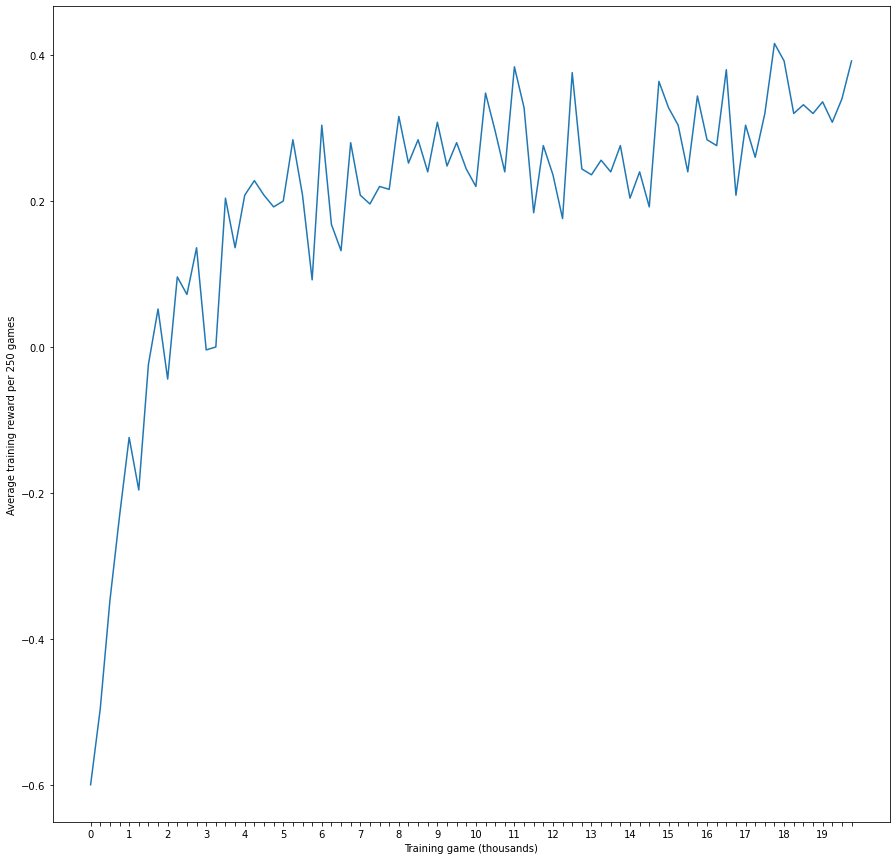

In [233]:
import matplotlib.pyplot as plt

q1_epsilon = 0.1 # Chosen because they use this in Q2 so this will allow us to nicely compare

q1_max_games = MAX_GAMES_DEFAULT
q1_q_learnt_player = QLearntPlayer(_epsilon=q1_epsilon)
print_Q_val_with_moves(q1_q_learnt_player._Q_values)
q1_avgs = []
q1_rewards = []
q1_total_wins = 0

for game_epoch in range(q1_max_games//250):
    if game_epoch % 10 == 0:
        print('Game ', game_epoch*250, ' begins.')
    run_rewards = run_n_games_against_opt(_max_games_number=250, _our_player=q1_q_learnt_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q1_epsilon, _update_q_values=True)
    q1_rewards+=run_rewards
    q1_avgs.append(np.average(run_rewards))
    q1_total_wins += sum(1 if rew ==1 else 0 for rew in run_rewards)

print('Our agent won {} times'.format(q1_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q1_avgs)
plt.xticks(ticks=range(len(q1_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q1_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

## Question 2. 
Plot average reward for every 250 games during training. Does decreasing epsilon help training
compared to having a fixed epsilon? What is the effect of n∗?
Expected answer: A figure showing average reward over time for different values of n∗ (caption length < 200 words)

In [18]:
q2_max_games = MAX_GAMES_DEFAULT
q2_n_stars =  np.geomspace(1, 40000, num=5) # Includes 1 and 40000
q2_epoch_size = 250
q2_rewards = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_avgs = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_M_opt = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_M_rand = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_total_wins = {n_star_q2: 0 for n_star_q2 in q2_n_stars}

q2_players = {}

q2_min_epsilon = 0.1
q2_max_epsilon = 0.8
def q2_calc_epsilon_factory(n_star_q2, epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*q2_epoch_size + game_number_n
            return max(q2_min_epsilon, q2_max_epsilon*(1-(real_game_number/n_star_q2)))
        return _calc_epsilon

for n_star_q2 in q2_n_stars:
    # epsilons.append([])
    q2_starting_epsilon  = q2_calc_epsilon_factory(n_star_q2, q2_epoch_size, 0)(0)
    q2_q_learnt_player = QLearntPlayer(_epsilon=q2_starting_epsilon)
    q2_players[n_star_q2] = q2_q_learnt_player
    print('Current n_star_q2 = {}'.format(n_star_q2))

    for game_epoch in range(q2_max_games//q2_epoch_size):
        q2_calc_epsilon = q2_calc_epsilon_factory(n_star_q2=n_star_q2, epoch_size=q2_epoch_size, game_epoch=game_epoch)
        # print(game_epoch, q2_q_learnt_player._epsilon)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q2_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 2)
        q2_run_rewards = run_n_games_against_opt(_max_games_number=q2_epoch_size, _our_player=q2_q_learnt_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=q2_calc_epsilon, _update_q_values=True)
        q2_avgs[n_star_q2].append(np.average(q2_run_rewards))
        q2_rewards[n_star_q2] += q2_run_rewards
        q2_total_wins[n_star_q2] += sum(1 if rew ==1 else 0 for rew in q2_run_rewards)

        # Run 500 games for M_opt calculation
        q2_M_opt_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q2_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q2_M_opt[n_star_q2].append(np.average(q2_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q2_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q2_M_rand[n_star_q2].append(np.average(M_rand_rewards))




Current n_star_q2 = 1
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 5000
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 10000
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 20000
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 40000
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
won games per agent {1: 9489, 5000: 9318, 10000: 8825, 20000: 7500, 40000: 5713}


ModuleNotFoundError: No module named 'seaborn'

#### Plot the results

Text(0.5, 0, 'Training episode')

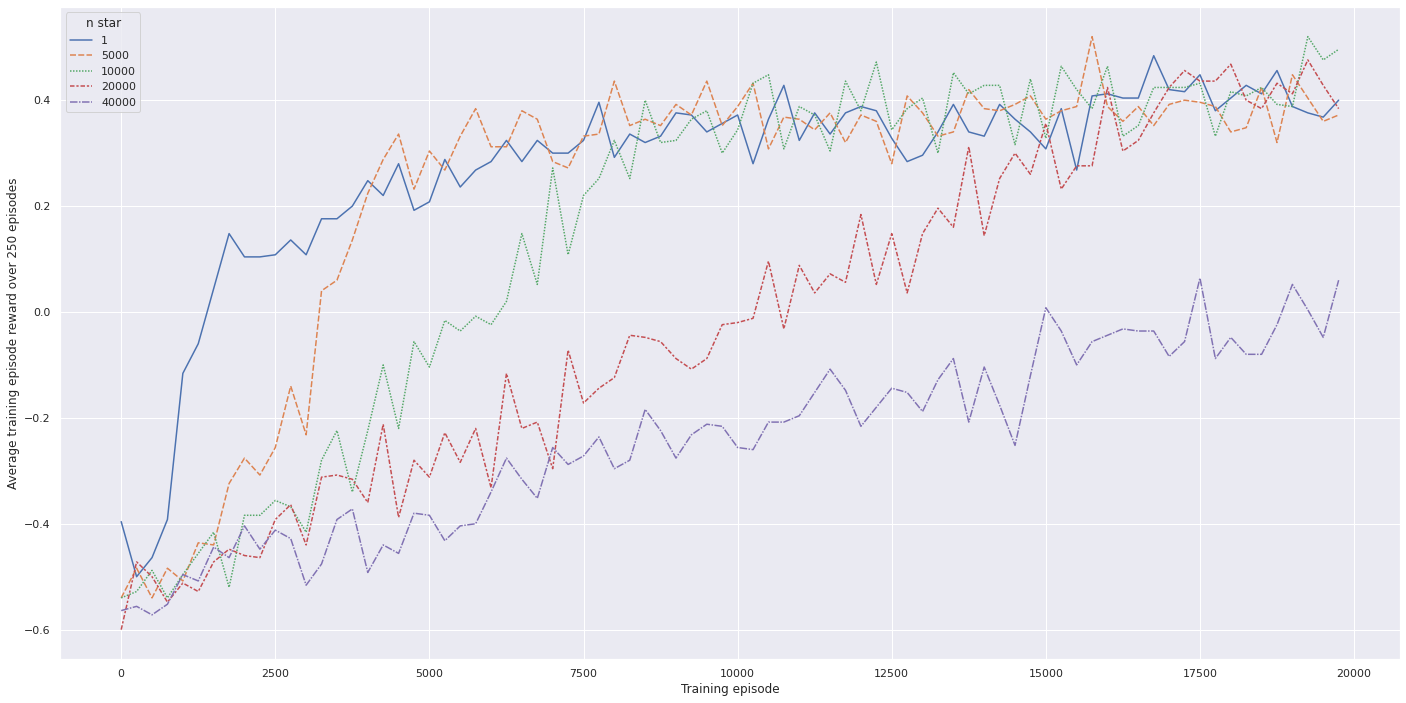

In [56]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# avgs = {n_star_q2: [] for n_star_q2 in q2_n_stars}
# for x in range(0,q2_max_games, 250):
#     lower_index = x
#     upper_index = min(x+250, q2_max_games-1)
#     for n_star_q2 in q2_n_stars:
#         slice = q2_rewards[n_star_q2][lower_index:upper_index]
#         avgs[n_star_q2].append(sum(slice)/len(slice))

q2_data = pd.DataFrame(q2_avgs, index =[250*i for i in range(20_000//250)] )

q2_data.transpose().index.name = 'n star'


sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_data)
g.set_ylabel('Average reward per game during training over 250 games')
g.set_xlabel('Training game')

## Question 3


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


episodes = [250*i for i in range(20_000//250)]
fig = plt.figure(figsize=(15,15))

colors = ["C"+str(j) for j in range(5)]

for i,(n_star, M_Rand_list) in enumerate(q2_M_rand.items()):
    plt.plot(episodes,M_Rand_list,linestyle="solid", color=colors[i], label = f"{n_star}")

for i,(n_star, M_Opt_list) in enumerate(q2_M_opt.items()):
    plt.plot(episodes, M_Opt_list,linestyle="-.",color=colors[i], label = f"{n_star}")
plt.legend()

plt.ylabel('M')
plt.xlabel('Training game')

plt.show()

NameError: name 'q2_M_rand' is not defined

<Figure size 1080x1080 with 0 Axes>

# Question 4
Choose the best value of $n^∗$ that you found in the previous section. Run Q-learning against Opt($\epsilon_{opt}$) for
different values of $\epsilon_{opt}$ for 20’000 games – switch the 1st player after every game. Choose several values
of $\epsilon_{opt}$ from a reasonably wide interval between 0 to 1 – particularly, include $\epsilon_{opt}$ = 0.


In [6]:
best_n_star = 1

In [15]:
q4_max_games = MAX_GAMES_DEFAULT
q4_epoch_size = 250

q4_eps_opts = np.linspace(0,1,num=5)

q4_rewards_eps = {eps_opt: [] for eps_opt in q4_eps_opts}
q4_M_opt_eps = {eps_opt: [] for eps_opt in q4_eps_opts}
q4_M_rand_eps = {eps_opt: [] for eps_opt in q4_eps_opts}

q4_min_epsilon = 0.1
q4_max_epsilon = 0.8


def q4_calc_epsilon_factory_eps(epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(q4_min_epsilon, q4_max_epsilon*(1-(real_game_number/best_n_star)))
        return _calc_epsilon

for eps_opt in q4_eps_opts:
    q4_starting_epsilon  = q4_calc_epsilon_factory_eps(q4_epoch_size, 0)(0)
    q4_q_learnt_player = QLearntPlayer(_epsilon=q4_starting_epsilon)
    print('Current eps_opt = {}'.format(eps_opt))

    for game_epoch in range(q4_max_games//q4_epoch_size):
        q4_calc_epsilon = q4_calc_epsilon_factory_eps(epoch_size=q4_epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q4_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 4)
        q4_run_rewards = run_n_games_against_opt(_max_games_number=q4_epoch_size, _our_player=q4_q_learnt_player, _opponent_epsilon=eps_opt, \
            _our_player_new_game_epsilon=q4_calc_epsilon, _update_q_values=True)
        q4_rewards_eps[eps_opt] += q4_run_rewards

        # Run 500 games for q4_M_opt_eps calculation
        q4_M_opt_eps_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q4_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q4_M_opt_eps[eps_opt].append(np.average(q4_M_opt_eps_rewards))


        # Run 500 games for q4_M_rand_eps calculation
        q4_M_rand_eps_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q4_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q4_M_rand_eps[eps_opt].append(np.average(q4_M_rand_eps_rewards))


Current eps_opt = 0.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.25
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.5
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.75
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 1.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


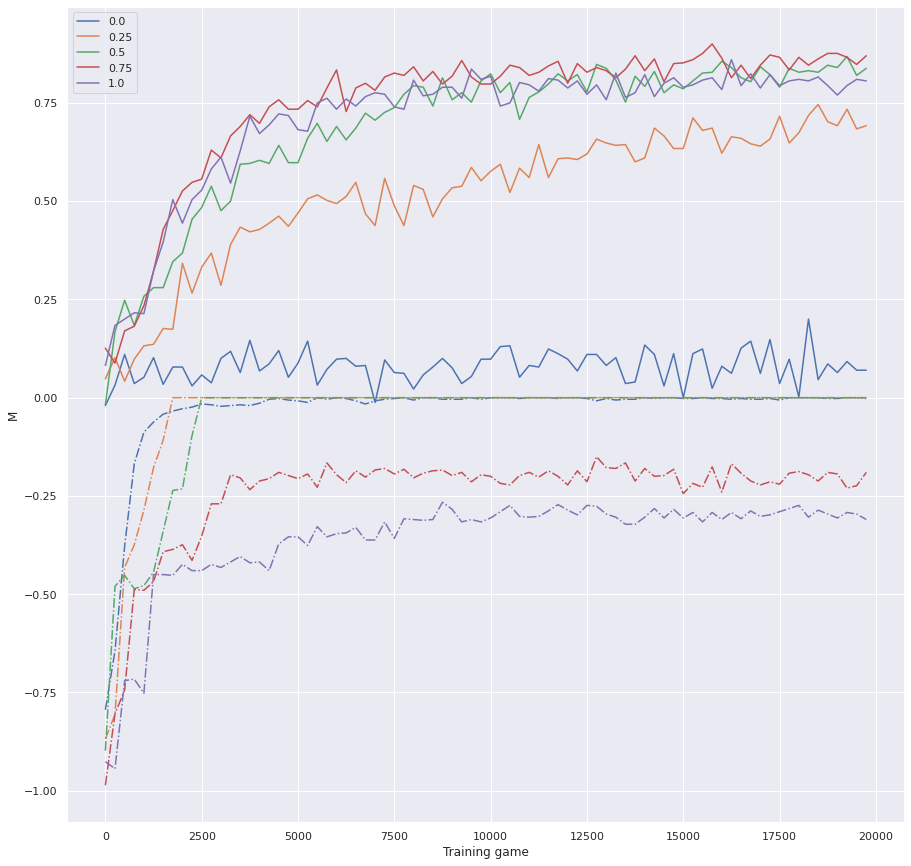

In [16]:


episodes = [250*i for i in range(20_000//250)]
fig = plt.figure(figsize=(15,15))

colors = ["C"+str(j) for j in range(5)]

for i,(eps, q4_M_rand_eps_list) in enumerate(q4_M_rand_eps.items()):
    plt.plot(episodes,q4_M_rand_eps_list,linestyle="solid", color=colors[i], label = f"{eps}")

for i,(eps, q4_M_opt_eps_list) in enumerate(q4_M_opt_eps.items()):
    plt.plot(episodes, q4_M_opt_eps_list,linestyle="-.",color=colors[i])
plt.legend()

plt.ylabel('M')
plt.xlabel('Training game')
plt.savefig("Q4.svg")
plt.show()


# Question 5
What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?

The highest value of $M_{opt}$ is achieved by $\epsilon=0.0$ and $\epsilon=0.25$ and it is the value 0 which is the best that we can hope for against  $M_{opt}$. The highest value of $M_{rand}$ is near $0.9$ achieved by  $\epsilon=0.75$ 



In [20]:
for eps in q4_M_rand_eps.keys():
    print(f"Epsilon: {eps} - Max M_rand : {max(q4_M_rand_eps[eps])}")

Epsilon: 0.0 - Max M_rand : 0.2
Epsilon: 0.25 - Max M_rand : 0.746
Epsilon: 0.5 - Max M_rand : 0.868
Epsilon: 0.75 - Max M_rand : 0.9
Epsilon: 1.0 - Max M_rand : 0.86


# 2.2 Learning by practice
In this section, your are supposed to ask whether Q-learning can learn to play Tic Tac Toe by only
playing against itself. For different values of $\epsilon \in [0, 1)$, run a Q-learning agent against itself for 20’000
games – i.e. both players use the same set of Q-values and update the same set of Q-values.



# Question 7 
 After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\epsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon \in [0, 1)$ (caption
length < 100 words).

In [187]:
def run_n_games_against_self(_max_games_number, _our_player, _our_player_new_game_epsilon, _update_q_values, _progress_print=None, _throw_error_on_illegal_moves = True):
    _rewards = {'our_player': [None for _ in range(_max_games_number)],'opponent': [None for _ in range(_max_games_number)]}
    _turns = ['X','O']
    if isinstance(_our_player,QLearntPlayer):
        # Added this branch to make this work for DQN also. 
        opponent = QLearntPlayer(_our_player._epsilon,_our_player._discount_rate_gamma, _our_player._learning_rate_alpha)

        # Ensure they share Q_values... I think this should just work
        opponent._Q_values = _our_player._Q_values

    # ! TODO: Make this also work for DQN_Player
    # if isinstance(_our_player, DQN_Player):
        # ! Init DQN opponent here.
        # ! THere are problems with defining this function this way as when it runs,
        # DQN player is not yet defined. Perhaps these two branches could be unified, but I leave this to
        # you Alex:)
        # raise NotImplementedError


    for game in range(_max_games_number):
        if _progress_print and game % _progress_print == 0:
            print('Game ', game, ' begins.')
        env.reset()
        _current_grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent = opponent.prepare_new_game_(_turns[0])
        _our_player = _our_player.prepare_new_game_(_turns[1])
        assert opponent._player != _our_player._player
        _our_player._epsilon = _our_player_new_game_epsilon(game_number_n=game)
        opponent._epsilon = _our_player_new_game_epsilon(game_number_n=game)

        for turn in range(9):
            opponent_turn = env.current_player == opponent._player
            if opponent_turn:
                chosen_move = opponent.choose_move_(_current_grid)
            else:
                chosen_move = _our_player.choose_move_(_current_grid)

            if (not _throw_error_on_illegal_moves) and (chosen_move not in get_empty_positions_from_grid(_current_grid)):
                # Added this branch to enable this function to be used for DQN also (jl, may 7)
                _current_grid = None
                _end = True
                # Whoever makes an illegal move loses, but should the other player observe reward
                # or should they just see reward as 0? Not sure (jl, May 7)
                _our_player_reward = 1 if opponent_turn else -1
                _opponent_reward = -1 if opponent_turn else 1

            else:
                _current_grid, _end, winner = env.step(chosen_move, print_grid=False)
                _our_player_reward = env.reward(_our_player._player)
                _opponent_reward = env.reward(opponent._player)

            if _end:
                _update_q_values and _our_player.update_q_values_(_current_grid, game_over = _end, _reward=_our_player_reward)
                _update_q_values and opponent.update_q_values_(_current_grid, game_over = _end, _reward=_opponent_reward)
                _rewards['our_player'][game] = _our_player_reward
                _rewards['opponent'][game] = _opponent_reward
                break
            elif turn !=0 and _update_q_values:
                if opponent_turn:
                    _our_player.update_q_values_(_current_grid, game_over = _end, _reward=_our_player_reward)
                else:
                    opponent.update_q_values_(_current_grid, game_over = _end, _reward=_opponent_reward)
    return _rewards

#### Run the experiments

In [188]:
q7_max_games = MAX_GAMES_DEFAULT
q7_epoch_size = 250

q7_eps_selfs = np.linspace(0,0.99,num=5)

q7_M_opt_self = {eps_opt: [] for eps_opt in q7_eps_selfs}
q7_M_rand_self = {eps_opt: [] for eps_opt in q7_eps_selfs}

q7_min_epsilon = 0.1
q7_max_epsilon = 0.8

n_star = None
calc_epsilon = None

for eps_s in q7_eps_selfs:
    q7_q_learnt_player = QLearntPlayer(_epsilon=q7_min_epsilon)
    print('Current eps_s = {}'.format(eps_s))

    for game_epoch in range(q7_max_games//q7_epoch_size):
        q7_calc_epsilon = lambda game_number_n: eps_s
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q7_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 7)
        run_rewards = run_n_games_against_self(_max_games_number=q7_epoch_size, _our_player=q7_q_learnt_player, \
            _our_player_new_game_epsilon=q7_calc_epsilon, _update_q_values=True)

        # Run 500 games for q7_M_opt_self calculation
        q7_M_opt_self_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q7_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q7_M_opt_self[eps_s].append(np.average(q7_M_opt_self_rewards))


        # Run 500 games for q7_M_rand_self calculation
        q7_M_rand_self_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q7_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q7_M_rand_self[eps_s].append(np.average(q7_M_rand_self_rewards))


Current eps_s = 0.5
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


#### Plot results

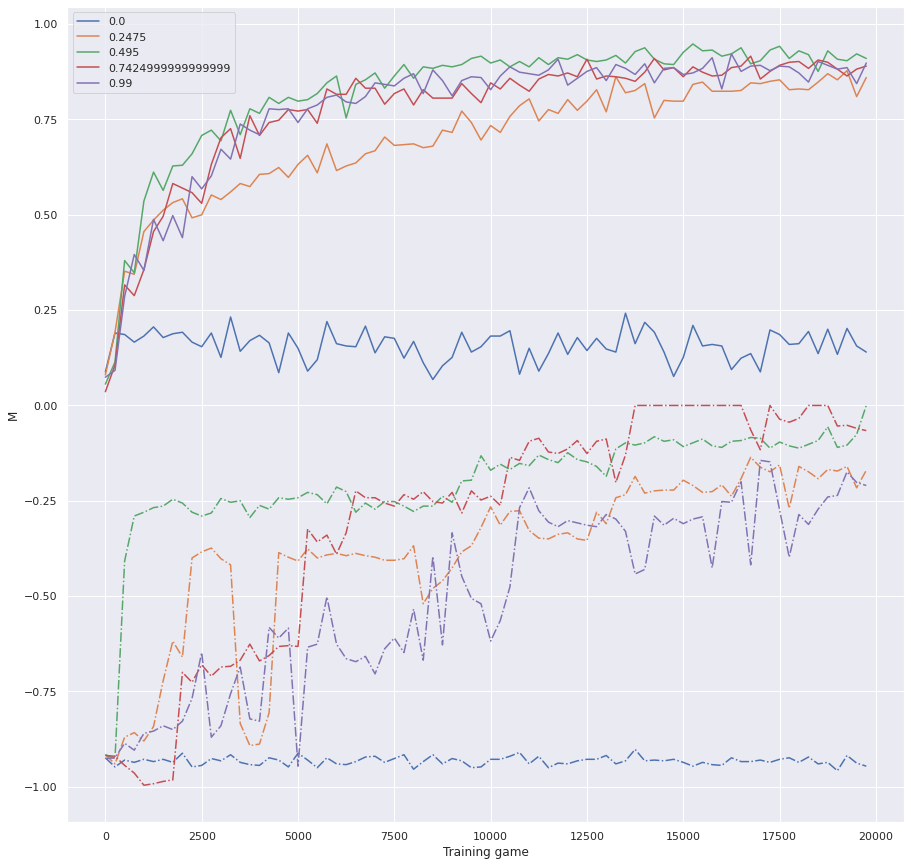

In [24]:

episodes = [250*i for i in range(20_000//250)]
fig = plt.figure(figsize=(15,15))

colors = ["C"+str(j) for j in range(5)]

for i,(n_star, q7_M_rand_eps_list) in enumerate(q7_M_rand_self.items()):
    plt.plot(episodes,q7_M_rand_eps_list,linestyle="solid", color=colors[i], label = f"{n_star}")

for i,(n_star, q7_M_opt_eps_list) in enumerate(q7_M_opt_self.items()):
    plt.plot(episodes, q7_M_opt_eps_list,linestyle="-.",color=colors[i])
plt.legend()

plt.ylabel('M')
plt.xlabel('Training game')
plt.savefig("Q7.svg")
plt.show()

# Question 8 
For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\epsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

#### Run the experiment

In [131]:
q8_max_games = MAX_GAMES_DEFAULT
q8_n_stars =  np.geomspace(1, 40000, num=5) # Includes 1 and 40000
epoch_size = 250

q8_rewards_self_n_stars = {n_star_q8: {'our_player': [], 'opponent':[]} for n_star_q8 in q8_n_stars}
q8_M_opt_self_n_stars = {n_star_q8: [] for n_star_q8 in q8_n_stars}
q8_M_rand_self_n_stars = {n_star_q8: [] for n_star_q8 in q8_n_stars}

q8_min_epsilon = 0.1
q8_max_epsilon = 0.8
def q8_calc_epsilon_factory(n_star_q8, epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(q8_min_epsilon, q8_max_epsilon*(1-(real_game_number/n_star_q8)))
        return _calc_epsilon

for n_star_q8 in q8_n_stars:
    q8_q_learnt_player = QLearntPlayer(_epsilon=q8_max_epsilon)
    print('Current n_star_q8 = {}'.format(n_star_q8))

    for game_epoch in range(q8_max_games//epoch_size):
        q8_calc_epsilon = q8_calc_epsilon_factory(n_star_q8=n_star_q8, epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 8)
        run_rewards = run_n_games_against_self(_max_games_number=epoch_size, _our_player=q8_q_learnt_player, \
            _our_player_new_game_epsilon=q8_calc_epsilon, _update_q_values=True)
        q8_rewards_self_n_stars[n_star_q8]['our_player'] += run_rewards['our_player']
        q8_rewards_self_n_stars[n_star_q8]['opponent'] += run_rewards['opponent']

        # Run 500 games for q8_M_opt_self_n_stars calculation
        q8_M_opt_self_n_stars_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q8_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q8_M_opt_self_n_stars[n_star_q8].append(np.average(q8_M_opt_self_n_stars_rewards))


        # Run 500 games for q8_M_rand_self_n_stars calculation
        q8_M_rand_self_n_stars_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q8_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q8_M_rand_self_n_stars[n_star_q8].append(np.average(q8_M_rand_self_n_stars_rewards))



Current n_star_q8 = 1
Game  0  begins.


NameError: name 'run_n_games_against_self' is not defined

#### Plot the results

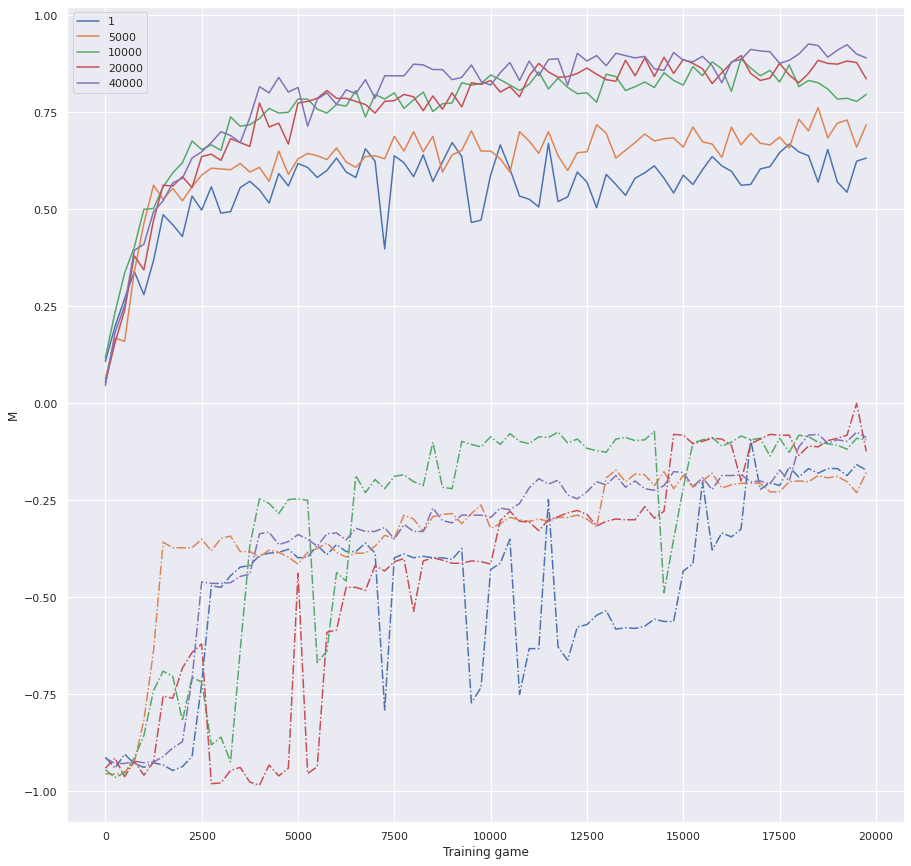

In [29]:

episodes = [250*i for i in range(20_000//250)]
fig = plt.figure(figsize=(15,15))

colors = ["C"+str(j) for j in range(5)]

for i,(n_star, q8_M_rand_list) in enumerate(q8_M_rand_self_n_stars.items()):
    plt.plot(episodes,q8_M_rand_list,linestyle="solid", color=colors[i], label = f"{n_star}")

for i,(n_star, q8_M_opt_list) in enumerate(q8_M_opt_self_n_stars.items()):
    plt.plot(episodes, q8_M_opt_list,linestyle="-.",color=colors[i])
plt.legend()

plt.ylabel('M')
plt.xlabel('Training game')
plt.savefig("Q8.svg")
plt.show()

# Question 9
*Question 9. What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?*


In [31]:
print("Decreasing epsilon")
for n_star in q8_M_rand_self_n_stars.keys():
    print(f"N star: {n_star} - Max M_rand : {max(q8_M_rand_self_n_stars[n_star])}")

print("Fixed epsilon")
for eps in q7_M_rand_self.keys():
    print(f"Epsilon: {eps} - Max M_rand : {max(q7_M_rand_self[eps])}")

N star: 1 - Max M_rand : 0.672
N star: 5000 - Max M_rand : 0.762
N star: 10000 - Max M_rand : 0.888
N star: 20000 - Max M_rand : 0.896
N star: 40000 - Max M_rand : 0.926


# Question 10


In [212]:
def visualize_qvalues(agent, grids):
    fig, axs = plt.subplots( nrows=1,ncols = len(grids), figsize =(30,10))

    for i,grid in enumerate(grids):
        qvals = agent._Q_values[agent.hash_grid(grid)]
        val_on_grid = np.full((3, 3), np.inf)
        for (x,y) in qvals.keys():
            val_on_grid[x][y] = qvals[(x,y)]

        im = axs[i].matshow(val_on_grid, cmap="PiYG", vmax=0.5, vmin=-0.5)
        ofst = 0.15
        grid = np.transpose(grid)
        for x in range(3):
            for y in range(3):
                if grid[x][y] == 1:
                    axs[i].text(x-ofst, y+ofst,"X", fontsize=30)
                elif grid[x][y] == -1:
                    axs[i].text(x-ofst, y+ofst,"O", fontsize=30)
        plt.colorbar(im, ax=axs[i], label="Q-values")

        

    plt.show()

[[0.58272103 0.18925311 0.3593434 ]
 [0.25303557 0.31182574 0.19253705]
 [0.32516832 0.22572103 0.57280634]]
[[        inf -0.63952577 -0.68677294]
 [-0.33560749  0.5610627          inf]
 [-0.53701677 -0.65251614         inf]]
[[inf inf inf]
 [ 0.  0.  0.]
 [inf  0.  0.]]


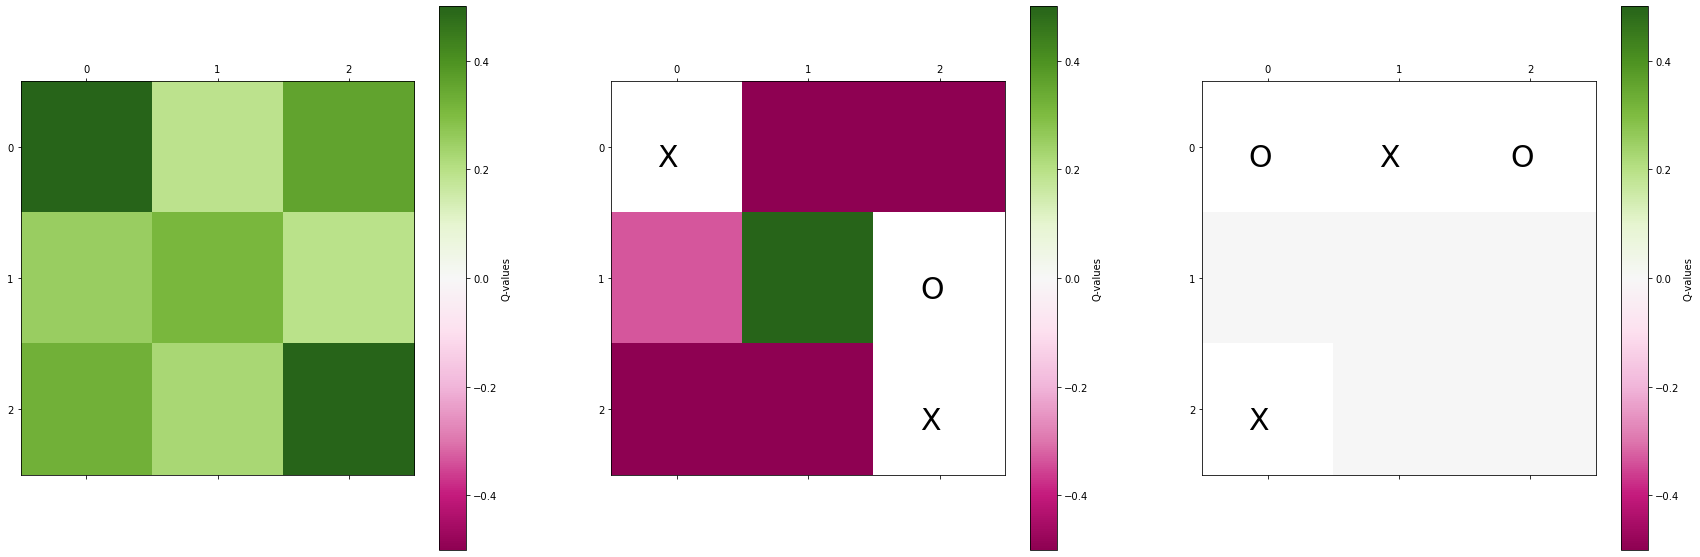

In [211]:
grids = [np.array([[0.,0., 0.], 
                 [ 0., 0., 0.], 
                 [0.,0.,0.]]), 
        np.array([[1.,0., 0.], 
                 [ 0.,0., -1.], 
                 [0.,0.,1.]]),
        np.array([[1.,0.,0.], 
                 [ -1., 0., 0.], 
                 [ 1.,-1.,0.]])]

                 #player X (1) moves first: if nb of eq pieces, it's X else it's O (-1)

visualize_qvalues(q7_q_learnt_player, grids)


# 3 Deep Q-Learning
As our 2nd algorithm, we use Deep Q-Learning (DQN) combined with $\epsilon$-greedy policy. You can watch
again Part 1 of Deep Reinforcement Learning Lecture 1 for an introduction to DQN and Part 1 of
Deep Reinforcement Learning Lecture 2 (in particular slide 8) for more details. The idea in DQN is
to approximate Q-values by a neural network instead of a look-up table as in Tabular Q-learning. For
implementation, you can use ideas from the DQN tutorials of Keras and PyTorch.

# 3.2 Learning from experts
Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary
$\epsilon \in [0,1)$ against Opt(0.5) for 20’000 games – switch the 1st player after every game.

## Question 11
*Plot average reward and average training loss for every 250 games during training. Does
the loss decrease? Does the agent learn to play Tic Tac Toe?
Expected answer: A figure with two subplots (caption length $<$ 50 words). Specify your choice of $\epsilon$.*

**Answer:** We use $\epsilon = 0.05$ as that is the value that Mnih et al (2015) use.

In [222]:
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def state_to_torch(game_state: np.ndarray):
    torch_no_batch =  torch.cat((torch.from_numpy((game_state == 1).astype(np.float32)).view(1,3,3,1), torch.from_numpy((game_state == -1).astype(np.float32)).view(1,3,3,1)), dim=3).to(device)
    return torch_no_batch

def game_state_converts_to_pytorch_correctly():
    game_state = np.array([ [ 1.,  1.,  1.], \
                            [ 1.,  0., -1.], \
                            [-1., -1.,  1.]])
    torch_repre = state_to_torch(game_state).view(3,3,2)
    expected_our_positions = torch.from_numpy((game_state==1).astype(int))
    torch_repre_our_positions = torch_repre[:,:,0]
    assert (expected_our_positions == torch_repre_our_positions).all()
    expected_opponent_positions = torch.from_numpy((game_state==-1).astype(int))
    torch_repre_opponent_positions = torch_repre[:,:,1]
    assert (expected_opponent_positions == torch_repre_opponent_positions).all()
    return True

assert game_state_converts_to_pytorch_correctly()

In [223]:
# This cell's code is largely taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html?highlight=huber

from collections import namedtuple, deque
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        # " Once a bounded length deque is full, when new items are added, a corresponding number
        # of items are discarded from the opposite end. " (https://docs.python.org/3/library/collections.html#collections.deque)
        self.memory = deque([],maxlen=capacity)

    def push(self, _new_memory: Transition):
        """Save a transition"""
        self.memory.append(_new_memory)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [224]:
class DQNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net =  nn.Sequential(
            nn.Linear(18, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 9))

    def forward(self, inp):
        batch_size = inp.size(0)
        input_in_1D = inp.view(batch_size,-1)
        output = self.net(input_in_1D)
        return output

summary(DQNet().to(device), input_size=(3,3,2))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       2,432
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       16,512
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       1,161
Total params: 20,105
Trainable params: 20,105
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       2,432
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       16,512
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       1,161
Total params: 20,105
Trainable params: 20,105
Non-trainable params: 0

In [225]:
eg_tensor = torch.tensor([0.1,0.2]  +5*[0] + [-0.3,-0.4]).view(9,-1)
eg_tensor.numpy().reshape(9)

array([ 0.1,  0.2,  0. ,  0. ,  0. ,  0. ,  0. , -0.3, -0.4],
      dtype=float32)

In [226]:
class DQN_Player(BasePlayer):
    INDEX_TO_POSITIONS = BasePlayer().get_empty_positions(TictactoeEnv().grid)
    POSITIONS_TO_INDEX = {position: index for index, position in enumerate(INDEX_TO_POSITIONS)}
    LEARNING_RATE = 5 * 10e-4 # Given in the instructions PDF
    DISCOUNT_RATE_GAMMA = 0.99
    DEFAULT_BATCH_SIZE = 64
    DEFAULT_BUFFER_SIZE = 10_000
    TARGET_NEW_UPDATE_FREQUENCY = 500

    def __init__(self, _epsilon: float, _batch_size = DEFAULT_BATCH_SIZE, _replay_buffer_size = DEFAULT_BUFFER_SIZE):
        self._policy_net = DQNet()
        self._target_net = DQNet()
        self._target_net.load_state_dict(self._policy_net.state_dict())
        self._replay_buffer = ReplayMemory(_replay_buffer_size)
        self._optimizer = torch.optim.Adam(self._policy_net.parameters(), lr=DQN_Player.LEARNING_RATE)
        self._criterion = nn.SmoothL1Loss() # "When delta is set to 1, this loss is equivalent to SmoothL1Loss." (PyTorch HuberLoss documentation)
        self._epsilon = _epsilon
        self._latest_memory = {'state': None, 'action': None, 'next_state': None, 'reward': None}
        self._player = None # 'X' or 'O'
        self._game_count = 0
        self._batch_size = _batch_size
        self._replay_buffer_size = _replay_buffer_size

    def prepare_new_game_(self, _player):
        # These assertions make sense when we are learning but they get broken
        # during M_opt and M_rand calculations
        # assert self._latest_memory['state'] is None
        # assert self._latest_memory['action'] is None
        # assert self._latest_memory['next_state'] is None
        # assert self._latest_memory['reward'] is None
        assert _player == 'X' or _player == 'O'
        self._player = _player
        self._game_count += 1
        return self

    def get_q_values_from_network(self, _torch_grid):
        with torch.no_grad():
            net_q_vals = self._policy_net(_torch_grid)
            # This is slow and it would be easier to just take the max but I implement it like this for easier debugging
            # Also this is consistent with previous Q-value representation, which will allow us to reuse debugging functions
            numpy_q_vals = net_q_vals.numpy().reshape(9)
            dict_q_vals = {move: numpy_q_vals[move_index] for (move_index, move) in enumerate(DQN_Player.INDEX_TO_POSITIONS)} 
            return dict_q_vals

    def get_max_val_action(self, _q_values):
        return max(_q_values, key=_q_values.get)

    def choose_move_(self, _grid):
        torch_grid = state_to_torch(_grid)

        random_sample = random.random()
        play_best_move = random_sample >= self._epsilon
        if play_best_move:
            q_values = self.get_q_values_from_network(_torch_grid=torch_grid)
            chosen_move = self.get_max_val_action(_q_values=q_values)
        else:
            possible_moves = self.get_empty_positions(_grid)
            chosen_move = random.choice(possible_moves)

        # These assertions make sense when we are learning but they get broken
        # during M_opt and M_rand calculations
        # assert self._latest_memory['state'] is None
        # assert self._latest_memory['action'] is None

        self._latest_memory['state'] = torch_grid
        self._latest_memory['action'] = torch.tensor([DQN_Player.POSITIONS_TO_INDEX[chosen_move]])

        if DEBUG:
            if not play_best_move:
                q_values = self.get_q_values_from_network(_torch_grid=torch_grid) # ensure q_values are defined
            print('-----------------------------------')
            print('Current position: ', '\n' + grid_to_string(_grid, False))
            print('Current Q-vals', q_values)
            print('Random sample ', random_sample, ' _epsilon ', self._epsilon, ' hence I chose ', \
                '*best*' if play_best_move else '*random*', ' move: ', chosen_move )
            print('-----------------------------------')

        return chosen_move

    def reset_latest_memory_(self):
        self._latest_memory['state'] = None
        self._latest_memory['action'] = None
        self._latest_memory['next_state'] = None
        self._latest_memory['reward'] = None

    def create_memory_(self, _next_state, _reward):
        # assert self._latest_memory['state'] is not None
        # assert self._latest_memory['action'] is not None
        # assert self._latest_memory['next_state'] is None
        # assert self._latest_memory['reward'] is None

        self._latest_memory['next_state'] = _next_state
        self._latest_memory['reward'] = torch.tensor([_reward])
        new_memory = Transition(**self._latest_memory)
        self._replay_buffer.push(new_memory)
        self.reset_latest_memory_()

    def learn_from_memories_(self):
        if len(self._replay_buffer) < self._batch_size:
            return
        replay_memories = self._replay_buffer.sample(self._batch_size)

        # next few lines inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training-loop
        batch = Transition(*zip(*replay_memories))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        non_final_mask = torch.tensor(tuple(map(lambda s: s != '', \
            batch.next_state)), device=device, dtype=torch.bool)

        non_final_next_states = state_batch[non_final_mask]

        _temp = self._policy_net(state_batch)





        pre_move_q_vals = _temp.gather(1, action_batch.view(action_batch.size(0),1))
        # print(action_batch)



        post_move_q_vals = torch.zeros(self._batch_size)

        # Don't call net if there are no non_final states in the batch
        if non_final_next_states.size(0) > 0:
            post_move_q_vals[non_final_mask] = self._target_net(non_final_next_states).max(1)[0].detach()
        expected_post_move_q_vals = (post_move_q_vals * self.DISCOUNT_RATE_GAMMA) + reward_batch

        # print(pre_move_q_vals.shape)
        loss = self._criterion(pre_move_q_vals, expected_post_move_q_vals.unsqueeze(1))
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        if self._game_count % self.TARGET_NEW_UPDATE_FREQUENCY == 0:
            self._target_net.load_state_dict(self._policy_net.state_dict())

    def update_q_values_(self, new_grid, game_over, _reward):
        """
        same signature and name as in QLearntPlayer in order to keep the same interface,
        even though another name would perhaps be more appropriate here
        """
        # If the next state is a final state, save '' instead: we need to signify the state is final
        # as the target network cannot predict the q-value of best action there since in a final state,
        # no action can be taken (we just give it Q-val of 0 instead)
        next_state = state_to_torch(new_grid) if not game_over else ''
        self.create_memory_(_next_state=next_state, _reward=_reward)
        self.learn_from_memories_()


In [228]:
import matplotlib.pyplot as plt

q11_epsilon = 0.1 # Chosen because they use this in q2 so this will allow us to nicely compare

q11_max_games = 20_000
q11_dqn_player = DQN_Player(_epsilon=q11_epsilon)
q11_epoch_size = 250
q11_rewards = []
q11_avgs = []
q11_M_opt = []
q11_M_rand = []
q11_total_wins = 0

for game_epoch in range(q11_max_games//q11_epoch_size):
    if game_epoch % 20 == 0:
        print('Game ', game_epoch*q11_epoch_size, ' begins.')

    # Run 250 games with updating Q-vals and observe reward (exec 2)
    q11_run_rewards = run_n_games_against_opt(_max_games_number=250, _our_player=q11_dqn_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q11_epsilon, _update_q_values=True, _throw_error_on_illegal_moves=False)
    q11_avgs.append(np.average(q11_run_rewards))
    q11_rewards += q11_run_rewards
    q11_total_wins += sum(1 if rew ==1 else 0 for rew in q11_run_rewards)

    with torch.no_grad():
        # Run 500 games for M_opt calculation
        q11_M_opt_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q11_dqn_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q11_M_opt.append(np.average(q11_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q11_dqn_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q11_M_rand.append(np.average(M_rand_rewards))

print('won games per agent', q11_total_wins)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print('Our agent won {} times'.format(q11_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q11_avgs)
plt.xticks(ticks=range(len(q11_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q11_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()


Game  0  begins.


NameError: name 'run_n_games_against_opt' is not defined

Text(0, 0.5, 'M_opt')

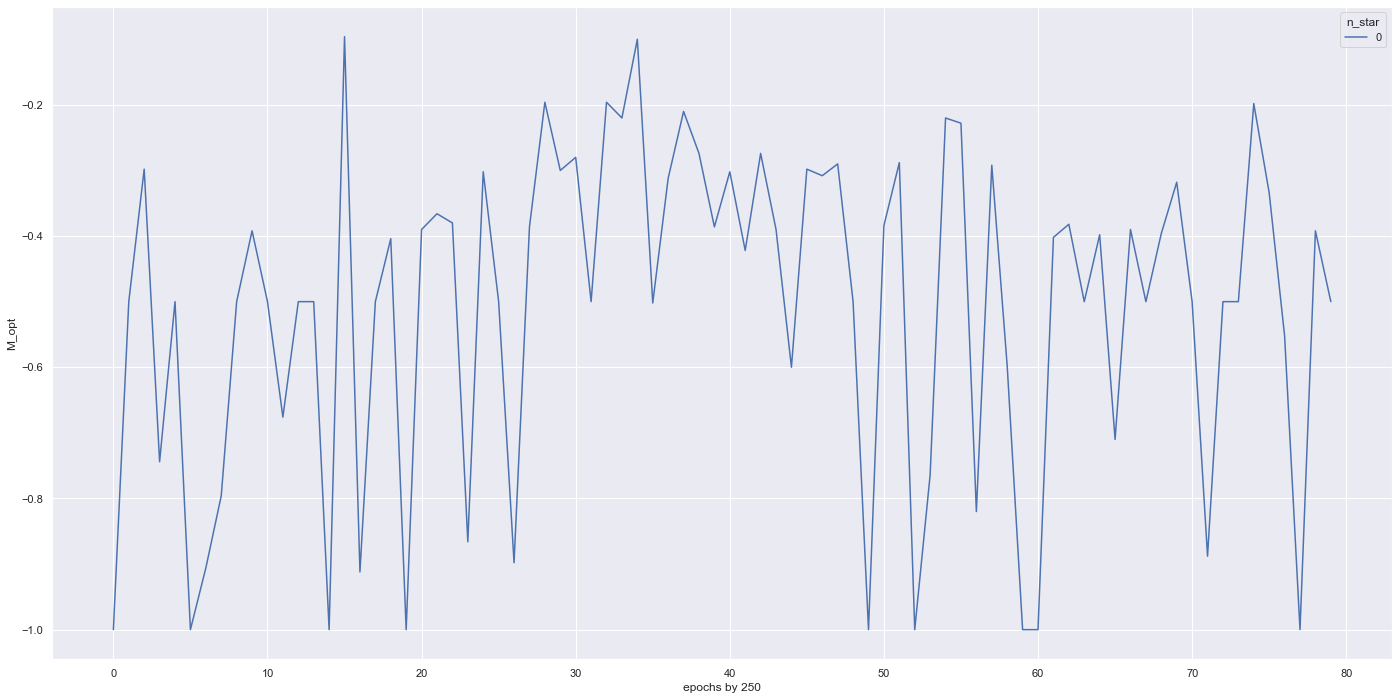

In [ ]:
q11_M_opt_df = pd.DataFrame(q11_M_opt)
q11_M_opt_df.index.name = 'epochs by 250'
q11_M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q11_M_opt_df)
g.set_ylabel('M_opt')

Text(0, 0.5, 'q11_M_rand')

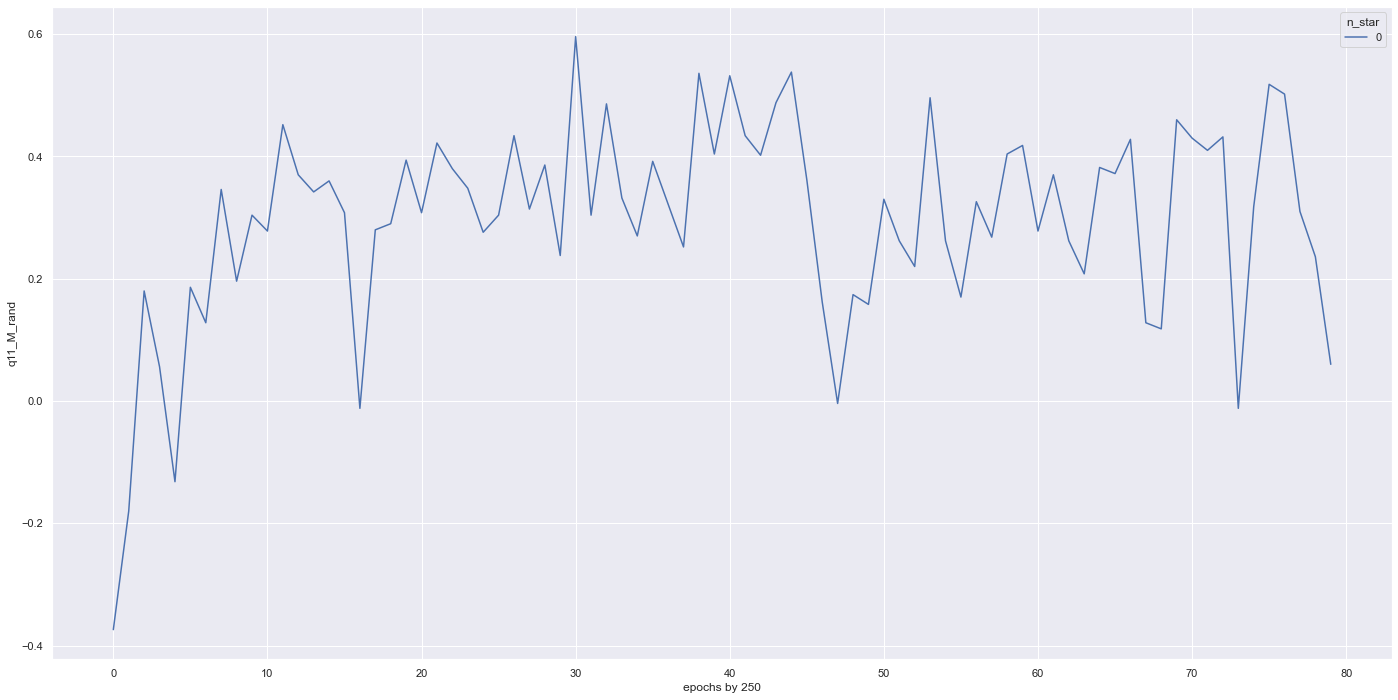

In [ ]:
q11_M_rand_df = pd.DataFrame(q11_M_rand)
q11_M_rand_df.index.name = 'epochs by 250'
q11_M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q11_M_rand_df)
g.set_ylabel('q11_M_rand')

# Q 12

Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
won games per agent 1918
Our agent won 1918 times


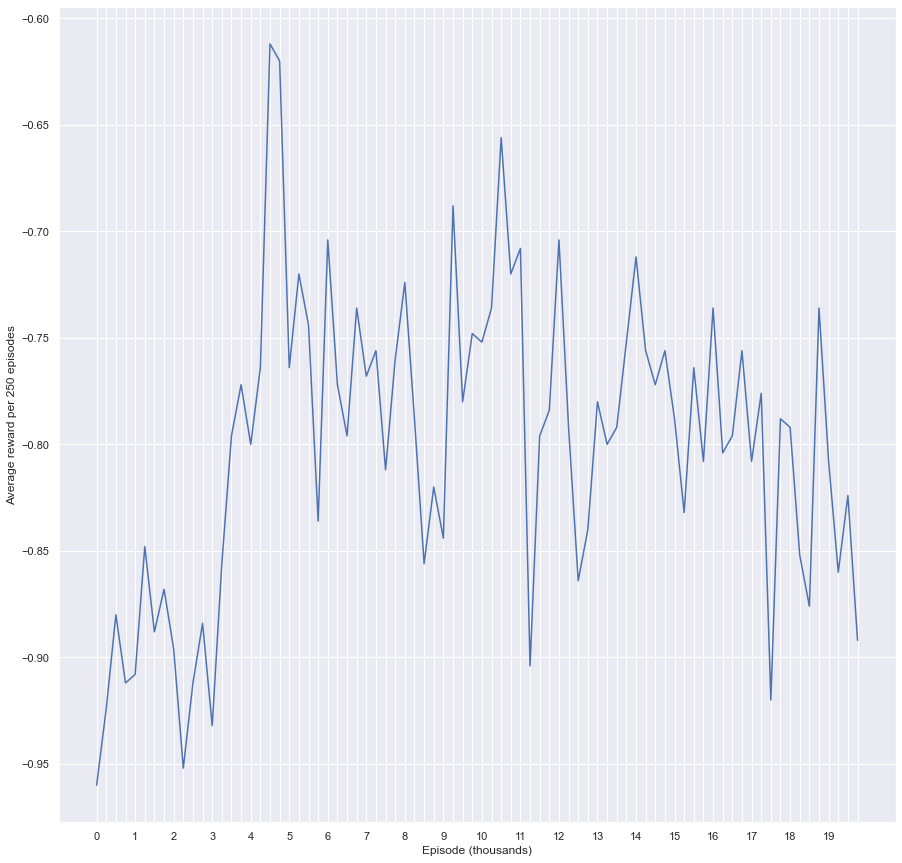

In [ ]:
import matplotlib.pyplot as plt

q12_epsilon = 0.1 # Chosen because they use this in q2 so this will allow us to nicely compare

q12_max_games = MAX_GAMES_DEFAULT
q12_dqn_player = DQN_Player(_epsilon=q12_epsilon, _batch_size=1, _replay_buffer_size=1)
q12_epoch_size = 250
q12_rewards = []
q12_avgs = []
q12_M_opt = []
q12_M_rand = []
q12_total_wins = 0

for game_epoch in range(q12_max_games//q12_epoch_size):
    if game_epoch % 20 == 0:
        print('Game ', game_epoch*q12_epoch_size, ' begins.')

    # Run 250 games with updating Q-vals and observe reward (exec 2)
    q12_run_rewards = run_n_games_against_opt(_max_games_number=250, _our_player=q12_dqn_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q12_epsilon, _update_q_values=True, _throw_error_on_illegal_moves=False)
    q12_avgs.append(np.average(q12_run_rewards))
    q12_rewards += q12_run_rewards
    q12_total_wins += sum(1 if rew ==1 else 0 for rew in q12_run_rewards)

    with torch.no_grad():
        # Run 500 games for M_opt calculation
        q12_M_opt_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q12_dqn_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q12_M_opt.append(np.average(q12_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q12_dqn_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q12_M_rand.append(np.average(M_rand_rewards))

print('won games per agent', q12_total_wins)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print('Our agent won {} times'.format(q12_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q12_avgs)
plt.xticks(ticks=range(len(q12_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q12_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()


Text(0, 0.5, 'M_opt')

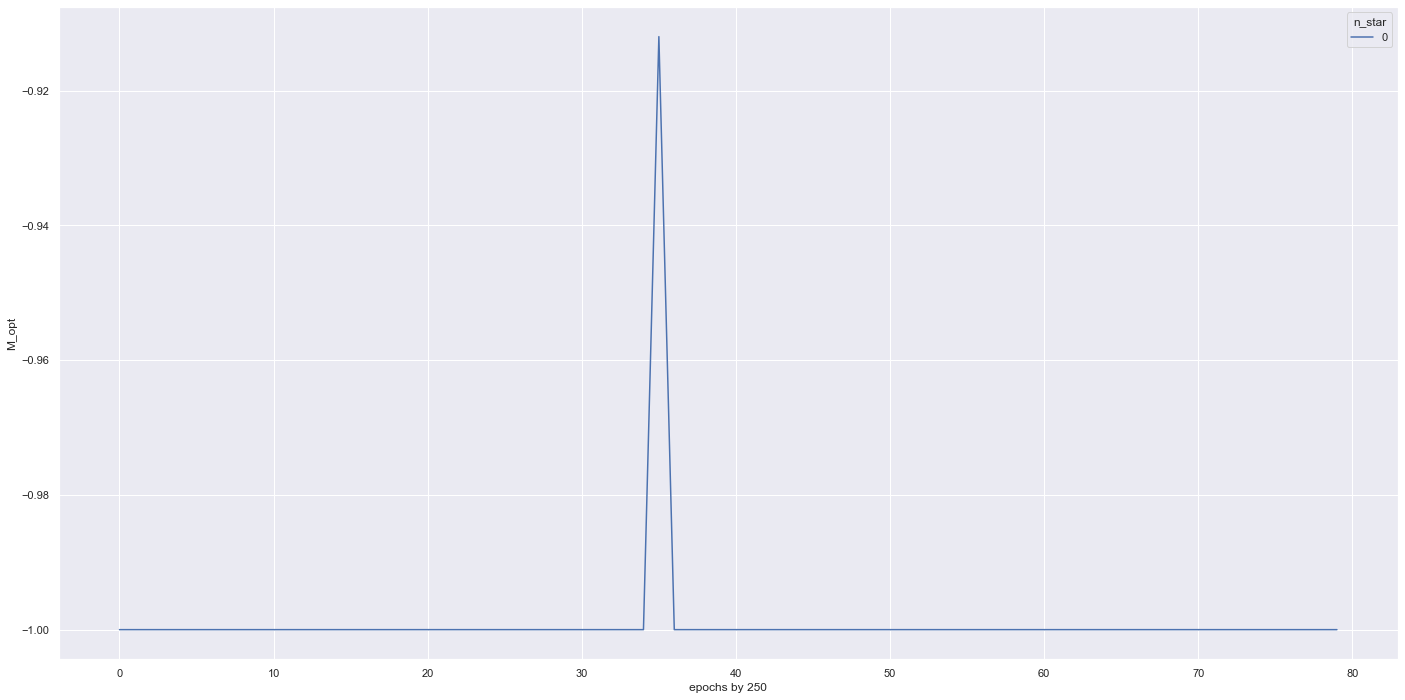

In [ ]:
q12_M_opt_df = pd.DataFrame(q12_M_opt)
q12_M_opt_df.index.name = 'epochs by 250'
q12_M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q12_M_opt_df)
g.set_ylabel('M_opt')

Text(0, 0.5, 'q12_M_rand')

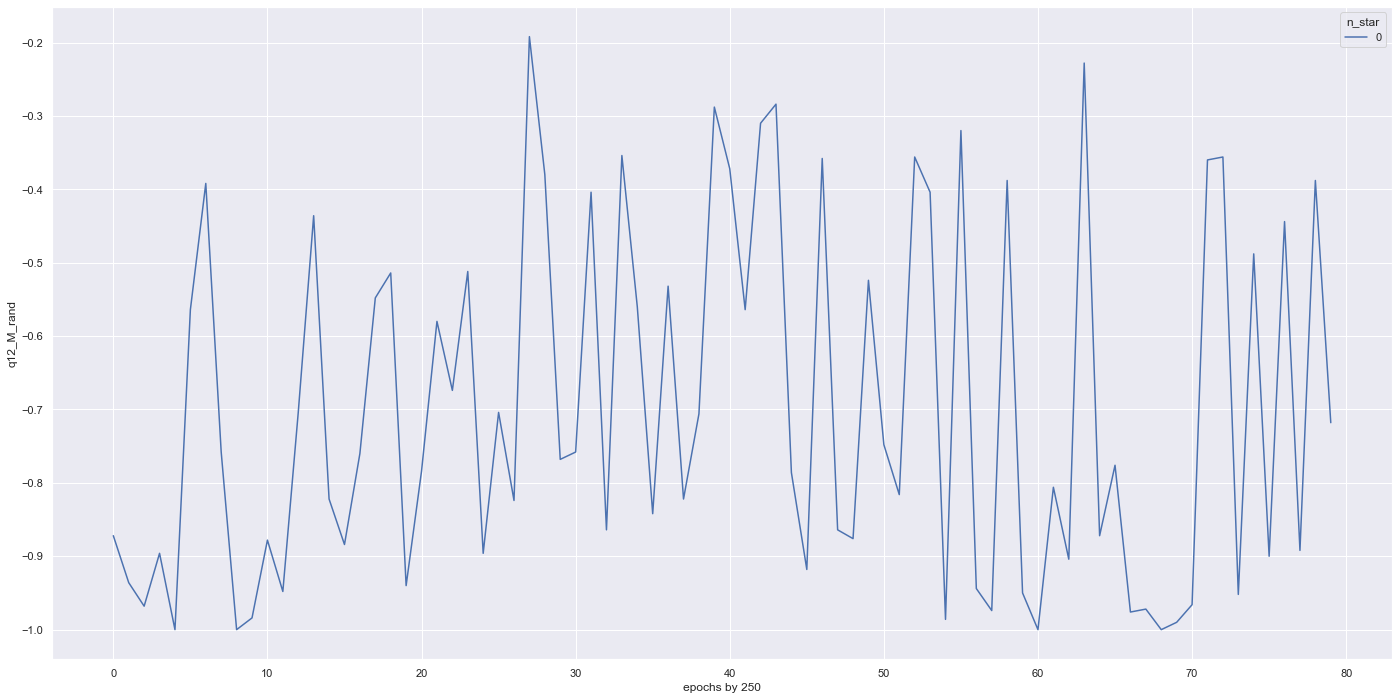

In [ ]:
q12_M_rand_df = pd.DataFrame(q12_M_rand)
q12_M_rand_df.index.name = 'epochs by 250'
q12_M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q12_M_rand_df)
g.set_ylabel('q12_M_rand')